# notMNIST classification using various deep learning methods

Firstly, import the data. All the images were preprocessed and saved into a ndarray object
and stored in a pickle file as a dictionary containing {test_dataset, test_labels, train_dataset, train_labels}

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function

In [4]:
file = pickle.load(open('notMNIST.pickle', 'rb'))
print(file.keys())

dict_keys(['test_dataset', 'test_labels', 'valid_dataset', 'train_labels', 'valid_labels', 'train_dataset'])


In [5]:
training_X = file['train_dataset']
training_Y = file['train_labels']

testing_X = file['test_dataset']
testing_Y = file['test_labels']

print('Training size', len(training_X))
print('Testing size', len(testing_X))

# the labels are stored as int values [0-9] for classes [A-J]
def get_label(i):
    return 'ABCDEFGHI'[i]

Training size 200000
Testing size 10000


Lets see what the dataset looks like. Each image was normalized before storing in order to reduce overfitting.

Label for the example show below is C


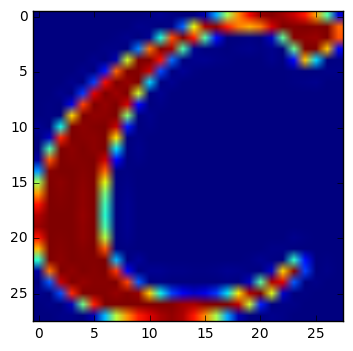

In [4]:
from random import randint
random_index = randint(0, 200000)
example = training_X[random_index]
print('Label for the example show below is', get_label(training_Y[random_index]))
plt.imshow(example)

For the sake of learning and save time, I will select a small subset of data for training and testing purpose.

In [5]:
training_X = training_X[0:10000]
training_Y = training_Y[0:10000]

testing_X = testing_X[0:1000]
testing_Y = testing_Y[0:1000]

print('Training size', len(training_X))
print('Testing size', len(testing_X))

Training size 10000
Testing size 1000


Multinomial logistic classification: Take the examples (X) and convert them into logits using WX + b. Then convert the output variables into probability ditribution using softmax. Compare the probability distribution with the one-hot encoding using cross entropy cost function. Here is the simplied formula

In [186]:
from IPython.display import Math
print('Logistic regression formula')
Math(r'F = \frac{1}{N}\sum_{i=1}^{N}H(\sigma (Wx{i}+b), L_{i})',)

Logistic regression formula


<IPython.core.display.Math object>

In [187]:
print('Sigmoid Function')
Math(r'\sigma = \frac{e^{z_{j}}}{\sum_{k=1}^{N} e^{z_{k}}}')

Sigmoid Function


<IPython.core.display.Math object>

In [188]:
print('Cross Entropy Function. S is the softmax probability and L is the one-hot encoding')
Math(r'H(S, L) = - \sum_{i=1}^{N} L_i * log(S_i)')

Cross Entropy Function. S is the softmax probability and L is the one-hot encoding


<IPython.core.display.Math object>

We need to flatten our tensor which is (N, (28,28)) into (N, 28*28) for the classifier to train

In [6]:
# flatten the tensor from [N, (x,y)] to [N, x*y] so we can input into our classifier
N,x,y = training_X.shape
train_X = np.reshape(training_X, (N, x*y))
N,x,y = testing_X.shape
test_X = np.reshape(testing_X, (N, x*y))

print('Training size', (train_X).shape)
print('Testing size', (test_X).shape)

Training size (200000, 784)
Testing size (10000, 784)


Using scikit learn library.

In [190]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(train_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
training_acc = classifier.score(train_X, training_Y)
testing_acc = classifier.score(test_X, testing_Y)
print('Training Accuracy', training_acc*100)
print('Testing Accuracy', testing_acc*100)

Training Accuracy 90.62
Testing Accuracy 88.0


Implementing **multinomial logistic regression** using tensorflow.
**Hyperparameters**
1. Number of epoch = 1000
2. Batch size = process all examples in one batch
3. Learning rate for gradient descent = 0.001
4. Cost Function = Cross entropy with softmax

In [21]:
#implement the multinomial logistic regression using tensorflow
x = tf.placeholder(tf.float32, [None, 784]) # 784 is input size because image size is (28*28) and we flatten it 
W = tf.Variable(tf.zeros([784, 10])) # input 784 output is 10
b = tf.Variable(tf.zeros([10]))
y_predicted = tf.add(tf.matmul(x, W),b) #predicted labels (prob-dist)
y_actual = tf.placeholder(tf.float32, [None, 10]) #actual labels

# cross entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_predicted, labels=y_actual)
cost = tf.reduce_mean(cross_entropy)

# gradient descent optmizer (backstep)
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

# initializer the variables
init = tf.global_variables_initializer()

We need to transform the output label into one hot encoding to input into our tensorflow

In [7]:
def one_hot_encoding(X):
    encoding = np.zeros([len(X), 10])
    encoding[np.arange(len(X)), X] = 1
    return encoding

training_encodedY = one_hot_encoding(training_Y)
testing_encodedY = one_hot_encoding(testing_Y)

In [23]:
sess = tf.Session()
sess.run(init)
cost_list = []
training_acc_list = []
testing_acc_list = []
for i in range(1,1001):
    avg_cost = 0.0
    train_acc = 0.0
    test_acc = 0.0
    _, c = (sess.run([optimizer, cost], feed_dict={x:train_X, y_actual:training_encodedY}))
    avg_cost += c
    cost_list.append(c)
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_actual, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    train_acc = sess.run(accuracy, feed_dict={x:train_X, y_actual:training_encodedY})
    test_acc = sess.run(accuracy, feed_dict={x:test_X, y_actual:testing_encodedY})
    training_acc_list.append(train_acc)
    testing_acc_list.append(test_acc)
    if i%100 == 0: 
        print('Epoch:', i, 'Cost', avg_cost, 'Training accuracy', train_acc, 'Testing accuracy', test_acc)
print('Finished')

Epoch: 100 Cost 2.05278277397 Training accuracy 0.6942 Testing accuracy 0.758
Epoch: 200 Cost 1.85547757149 Training accuracy 0.7098 Testing accuracy 0.772
Epoch: 300 Cost 1.69962894917 Training accuracy 0.7232 Testing accuracy 0.78
Epoch: 400 Cost 1.57517433167 Training accuracy 0.7351 Testing accuracy 0.794
Epoch: 500 Cost 1.47457921505 Training accuracy 0.7452 Testing accuracy 0.803
Epoch: 600 Cost 1.39222037792 Training accuracy 0.7519 Testing accuracy 0.813
Epoch: 700 Cost 1.3239171505 Training accuracy 0.7567 Testing accuracy 0.82
Epoch: 800 Cost 1.2665719986 Training accuracy 0.7626 Testing accuracy 0.824
Epoch: 900 Cost 1.21787798405 Training accuracy 0.7668 Testing accuracy 0.828
Epoch: 1000 Cost 1.17609751225 Training accuracy 0.7706 Testing accuracy 0.833
Finished


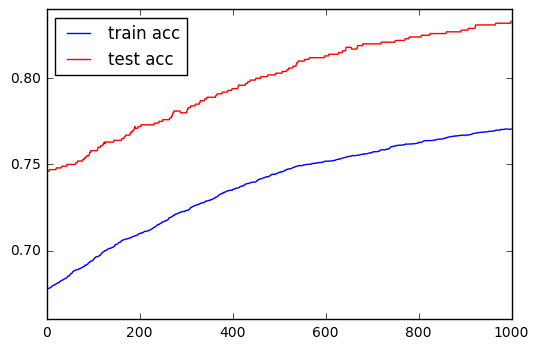

In [35]:
epochs = range(1000)
ax = plt.subplot(111)
ax.plot(epochs, training_acc_list,'b', label='train acc')
ax.plot(epochs, testing_acc_list, 'r', label='test acc')
ax.legend(loc = 'top left')
# ax.show()

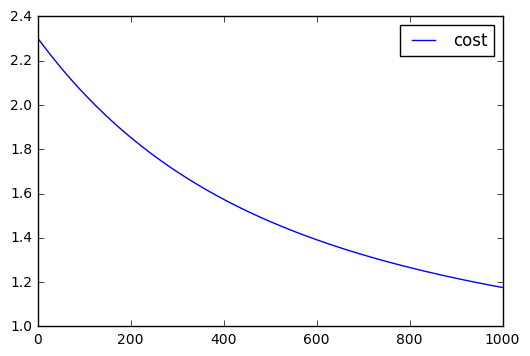

In [38]:
ax = plt.subplot(111)
ax.plot(cost_list, label = 'cost')
ax.legend(loc = "top right")

<hr>
Also some terminology:<br>
**epoch**: a complete forward and backward pass of *all* training examples<br>
**batch**: a sample of training examples in one pass<br>
**iteration**: total number of passes<br>
**General method**
```python
for e in epoch:
    iterations = num_of_training_examples/batch_size
    for i in iterations:
        x,y = next_batch(dataset, batch_size)
        train(x,y)
```
<hr>
**Task 1: **Optimizing using stochastic gradient descent. We use mini batch size of 128 which we use for finidng the gradient and passing that through weights and biases. SGD works amazing fast and scales well with large dataset when compared to regular gradient descent which uses the entire training dataset as one batch to learn the gradients.<br>

In [8]:
batch_size = 128
N, image_size, _ = training_X.shape
num_labels = 10

tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
tf_train_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_test_X = tf.constant(test_X)
tf_test_Y = tf.constant(testing_encodedY)

weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
biases = tf.Variable(tf.zeros([num_labels]))

logits = tf.matmul(tf_train_X, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_Y, logits=logits))
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

train_prediction = tf.nn.softmax(logits)
test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, weights) + biases)

def accuracy(predictions, actual):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(actual, 1)) / predictions.shape[0])

In [9]:
num_of_epochs = 10001
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initializing")
    for epoch in range(1,num_of_epochs):
        offset = (epoch*batch_size) % (training_encodedY.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :]
        batch_Y = training_encodedY[offset:(offset + batch_size), :]
        feed_dict = {tf_train_X:batch_X, tf_train_Y:batch_Y}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (epoch % 500 == 0):
            print('Epoch', epoch, '| Loss', l ,'| Training Acc', accuracy(predictions, batch_Y), '| Testing Acc', accuracy(test_prediction.eval(), testing_encodedY))

Initializing
Epoch 500 | Loss 1.75129 | Training Acc 75.0 | Testing Acc 83.59
Epoch 1000 | Loss 1.1439 | Training Acc 78.125 | Testing Acc 84.2
Epoch 1500 | Loss 0.915533 | Training Acc 86.71875 | Testing Acc 85.18
Epoch 2000 | Loss 0.678381 | Training Acc 84.375 | Testing Acc 85.51
Epoch 2500 | Loss 1.01636 | Training Acc 73.4375 | Testing Acc 85.24
Epoch 3000 | Loss 1.04729 | Training Acc 71.09375 | Testing Acc 85.95
Epoch 3500 | Loss 1.03023 | Training Acc 78.90625 | Testing Acc 86.41
Epoch 4000 | Loss 1.13343 | Training Acc 73.4375 | Testing Acc 86.48
Epoch 4500 | Loss 0.963309 | Training Acc 76.5625 | Testing Acc 86.78
Epoch 5000 | Loss 0.706823 | Training Acc 84.375 | Testing Acc 87.52
Epoch 5500 | Loss 0.687868 | Training Acc 81.25 | Testing Acc 87.5
Epoch 6000 | Loss 0.564703 | Training Acc 83.59375 | Testing Acc 87.59
Epoch 6500 | Loss 0.898403 | Training Acc 78.90625 | Testing Acc 86.02
Epoch 7000 | Loss 0.642737 | Training Acc 82.03125 | Testing Acc 87.79
Epoch 7500 | Loss 0

Here is the metric for SGD with a simple (y = Wx + b) logistic regression model using SGD optimizer<br>
**Epoch 10000 | Loss 0.262531 | Training Acc 93.75 | Testing Acc 86.3**

**Task 2:**Now we convert our SGD regression model into a neural network with 2 hidden layers. The regression model (either with gradient descent or SGD) is very limited when it comes to learning functions and it only optimized for learning linear functions (*note*: combinations of linear functions is also linear). Therefore, we need to introduce non-linearity into our model so that it can recognize complex non-linear patterns. One simple activation function that we will use to introduce non-linearity is **ReLU** (Rectified Linear Unit)

In [57]:
print('Training X', train_X.shape)
print('Training Y', training_encodedY.shape)
print('Testing X', test_X.shape)
print('Testing Y', testing_encodedY.shape)

Training X (10000, 784)
Training Y (10000, 10)
Testing X (1000, 784)
Testing Y (1000, 10)


In [12]:
batch_size = 128
N, image_size, _ = training_X.shape
num_labels = 10
beta = 0.001


tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
tf_train_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_test_X = tf.constant(test_X)
tf_test_Y = tf.constant(testing_encodedY)

keep_prob = tf.placeholder(tf.float32)

weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, 128]))
weights_2 = tf.Variable(tf.truncated_normal([128, num_labels]))

biases_1 = tf.Variable(tf.zeros([128]))
biases_2 = tf.Variable(tf.zeros([num_labels]))

logits_1 = tf.matmul(tf_train_X, weights_1) + biases_1
logits_1 = tf.nn.relu(logits_1)
logits_1 = tf.nn.dropout(logits_1, keep_prob)

logits_2 = tf.matmul(logits_1, weights_2) + biases_2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_Y, logits=logits_2)) \
+ beta * tf.nn.l2_loss(weights_1) + beta * tf.nn.l2_loss(weights_2) \
+ beta * tf.nn.l2_loss(biases_1) + beta * tf.nn.l2_loss(biases_2)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

train_prediction = tf.nn.softmax(logits_2)

test_prediction = tf.matmul(tf_test_X, weights_1) + biases_1
test_prediction = tf.nn.relu(test_prediction)
test_prediction = tf.matmul(test_prediction, weights_2) + biases_2
test_prediction = tf.nn.softmax(test_prediction)

def accuracy(predictions, actual):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(actual, 1)) / predictions.shape[0])

In [13]:
num_of_epochs = 10001
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initializing")
    for epoch in range(1,num_of_epochs):
        offset = (epoch*batch_size) % (training_encodedY.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :]
        batch_Y = training_encodedY[offset:(offset + batch_size), :]
        feed_dict = {tf_train_X:batch_X, tf_train_Y:batch_Y, keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (epoch % 500 == 0):
            print('Epoch', epoch, '| Loss', l ,'| Training Acc', accuracy(predictions, batch_Y), '| Testing Acc', accuracy(test_prediction.eval(), testing_encodedY))

Initializing
Epoch 500 | Loss 25.2891 | Training Acc 59.375 | Testing Acc 81.31
Epoch 1000 | Loss 14.7821 | Training Acc 73.4375 | Testing Acc 85.75
Epoch 1500 | Loss 9.06042 | Training Acc 77.34375 | Testing Acc 87.13
Epoch 2000 | Loss 5.61975 | Training Acc 79.6875 | Testing Acc 88.48
Epoch 2500 | Loss 3.92363 | Training Acc 72.65625 | Testing Acc 89.52
Epoch 3000 | Loss 2.64492 | Training Acc 75.78125 | Testing Acc 90.71
Epoch 3500 | Loss 1.79113 | Training Acc 82.03125 | Testing Acc 90.89
Epoch 4000 | Loss 1.3176 | Training Acc 78.125 | Testing Acc 91.09
Epoch 4500 | Loss 1.09534 | Training Acc 78.125 | Testing Acc 91.0
Epoch 5000 | Loss 0.800123 | Training Acc 85.15625 | Testing Acc 91.87
Epoch 5500 | Loss 0.741087 | Training Acc 82.8125 | Testing Acc 91.98
Epoch 6000 | Loss 0.598925 | Training Acc 84.375 | Testing Acc 91.91
Epoch 6500 | Loss 0.75354 | Training Acc 82.03125 | Testing Acc 92.01
Epoch 7000 | Loss 0.60099 | Training Acc 86.71875 | Testing Acc 91.94
Epoch 7500 | Loss 